# Component separation tutorial

This tutorial presents the component separation algorithm and its implementation. \
This algorithm is based on works described in Régaldo-Saint Blancard et al. 2021, Delouis et al. 2022 and Auclair et al. 2023.

## 1. Algorithm principle

We present the component separation algorithm.

### 1.1. Introduction

We consider a noisy data $d$ which is composed of a signal of interest $s$ and a noise $n$. We have then $d = s + n$. These maps are realizations of the statistical processes $D$, $S$ and $N$ with $D=S+N$. This algorithm aims at determining the statistics of $s$, including the non-Gaussian ones, knowing those of $d$ and a few realizations of $N$.

The non-Gaussian statistics we use are the Wavelet Phase Harmonics (WPH) statistics (see Allys et al. 2019, Régaldo-Saint Blancard et al. 2022). The WPH statistics have shown an impressive efficiency in characterizing non-Gaussian processes while having an explicit mathematical formalism without any training. See https://github.com/bregaldo/pywph for details on the WPH statistics computation. 

Since the WPH statistics are non-linear, the estimation of the statistics of $s$ from those of $d$ and $n$ can not be simply obtained by computing the statistics of $d$ minus those of $n$. This is why we developed this component separation algorithm.

### 1.2. General framework

The general framework of the algorithm is a gradient descent in pixel space in order to satisfy a statistical constraint. \
We denote by $u$ the running map which converges to $\tilde{s}$ the estimate of $s$. We also denote by $\Phi$ the WPH operator and by $\{ n_i \}_{i \leq M_n}$ the set of $M_n$ noise realizations.

The gradient descent is performed over the pixels of $u$ in order to statisfy the statistical constraint $\Phi(d) \simeq \Phi(u + n)$ of which $s$ is a solution.

This constraint can be written in two ways, corresponding to the loss functions of Bruno Régaldo-Saint Blancard's (see Régaldo Saint-Blancard et al. 2022) and Jean-Marc Delouis's (see Delouis et al. 2022) formalisms. 

### 1.3. Bruno Régaldo-Saint Blancard's (BR) formalism

In BR formalism, the loss function is defined as:

\begin{equation}
\displaystyle L(u) = \left\langle \left\lVert \frac{\Phi(d) - \Phi(u + n_i)}{\sigma_j(u + n_j)} \right\rVert^2 \right\rangle_i
\end{equation}

where $\lVert \cdot \rVert$ stands for the Euclidean norm, $\langle \cdot \rangle_i$ stands for the average over $i$ and $\sigma_j$ stands for the standard deviation over $j$.

### 1.4. Jean-Marc Delouis's (JMD) formalism

In JMD formalism, the loss function is defined as:

\begin{equation}
\displaystyle L(u) = \left\lVert \frac{\Phi(u) - (\Phi(d) - B(u))}{\sigma_j(u + n_j)} \right\rVert^2
\end{equation}

where $\lVert \cdot \rVert$ stands for the Euclidean norm, $\sigma_j$ stands for the standard deviation over $j$ and $B(u) = \langle \Phi(u+n_i)-\Phi(u) \rangle_i$ is the noise-induced bias on the map $u$.

### 1.5. Common features of the two formalisms

The overall architecture of the algorithm is the same in both formalisms.

#### 1.5.1. Epochs of optimization

In both formalisms, for computational reasons, the $\sigma_j(u+n_j)$ (and $B(u)$ in JMD formalism) is computed every $N_{iter}$ iteration. This leads to $N_{epoch}$ epochs of optimization at the beginning of which the standard deviation of the WPH statistics of $u+n_i$ (and the noise-induced bias in JMD formalism) are evaluated.

#### 1.5.2. Steps of optimization

The gradient descent is done in two steps, each containing $N_{epoch}$ epochs of $N_{iter}$ iterations. The first step starts from $u_0 = d$ and makes use of a subset of WPH coefficients containing only power-spectrum-like coefficients. The result of the first step is noted $\tilde{s}_0$. This map is a good estimate of $s$ in terms of power-spectrum but not in terms of non-Gaussian statistics since they have not been taken into account. The second step starts from $u_0 = \tilde{s}_0$ and makes use of the full set of WPH statistics. The result of the second step, that we denote by $\tilde{s}$, is the output of the component separation algorithm. 

#### 1.5.3. Threshold of the statistics

In both losses, the real and imaginary parts of the WPH statistics are processed separately. The set containing the real and imaginary parts of the WPH statistics is distributed in two close-to-Gaussian distributions separated by several orders of magnitude. We perform then a threshold of the $\sim 50 \%$ smallest WPH statistics that are not relevant and make the gradient descent more difficult.

### 1.6. Differences between the two formalisms

The differences between the two formalisms are quite significant.

#### 1.6.1. Mean of the distances or distance from the mean

There is first a conceptual difference between the two formalisms.

In BR formalism, the loss is computed as the mean of the normalized squared distances between $d$ and $u+n_i$ in the WPH statistics space. The quantity to minimize is a mean of distances which cannot become arbitrarily small. The WPH statistics involved are directly computed on maps.

In JMD formalism, the loss is computed as the normalized squared distance between $\Phi(u)$ and $\Phi(d) - B(u)$. The quantity to minimize is the distance between two points which can become arbitrarily small. The WPH statistics involved are computed using a subtraction as the debiasing of $\Phi(d)$. 

Here is a scheme which represents the conceptual difference between the loss computations in the two formalisms. 

![title](notebook_images/BR_vs_JMD_formalism.png)

The loss computations are done in the WPH statistics space, which is represented here in two dimensions for simplicity.  

In both cases, the red color stands for the addition of noise in pixel space, the blue color stands for the distance measurements in WPH statistics space and the green color stands for the iteration on the $u$ map. \
In BR formalism, the average distance between $d$ and $\{ u + n_i \}_i$ is computed. The gradient of the loss gives the direction to follow in the statistics space to minimize the average distance. \
In JMD formalism, the noise-induced mean bias $B(u)$ at the WPH statistics level is computed and removed from the WPH statistics of $d$. The pixels of $u$ are deformed such that $\Phi(u)$ moves towards $\Phi(d)-B(u)$.

#### 1.6.2. Computation time

There is an important difference in terms of computation time between the two formalisms.

The BR formalism involving a mean over $M_n$ WPH statistics computations in each iteration, it is much slower (about $M_n$ times) than JMD formalism.

#### 1.6.3. Consequences on the results

The two formalisms can give slightly different results. 

The JMD formalism uses a debiasing directly in the WPH statistics space whereas in BR formalism this is done purely in pixel space. This difference causes the pros and cons of both formalisms. The JMD formalism is a better way of debiasing statistics, but is exposed to instabilities, since statistics calculated by subtraction have no guarantee of being included in the set of possible statistics. The result obtained using JMD formalism are then almost noise-free but often present visual artifacts. The BR formalism guarantees that the target statistics are admissible, but has a harder time debiasing them. The result obtained using BR formalism are then very realistic but sometimes present a residual noise level.

## 2. Tutorial

We present the implementation of the component separation algorithm through an example on mock data. The parameters are here modified from the ones in component_separation.py in order to be able to run this notebook on a local CPU. A standard run of component_separation.py has to be done on a GPU. 

### 2.1. Imports

We first import the modules and functions that we will need. 

In [1]:
import warnings
warnings.filterwarnings('ignore')
import time
import numpy as np
import torch
import scipy
import scipy.optimize as opt
import matplotlib.pyplot as plt
import pywph as pw
import os 
cwd = os.getcwd()
import sys
sys.path.append(cwd)
from comp_sep_functions import create_batch, compute_bias_std, compute_mask, compute_loss_BR, compute_loss_JMD
from tools import plot, plot_PS, plot_wph

In [2]:
print("NumPy",np.__version__)
print("Torch",torch.__version__)
print("SciPy",scipy.__version__)
print("PyWPH",pw.__version__)

NumPy 1.24.3
Torch 2.1.2+cu121
SciPy 1.11.3
PyWPH 1.1.2


### 2.2. Data loading

Now, we load the "dust_simulation.npy" which is a simulation of Galactic dust done using the WST synthesis procedure (see Allys et al. 2019). The is a good example of a very non-Gaussian process, with strong couplings between scales due to the non-linear physics of the interstellar medium. This is our clean data `s`.

In [3]:
s = np.load('../Data/dust_simulation.npy').astype(np.float64)

We can plot it :

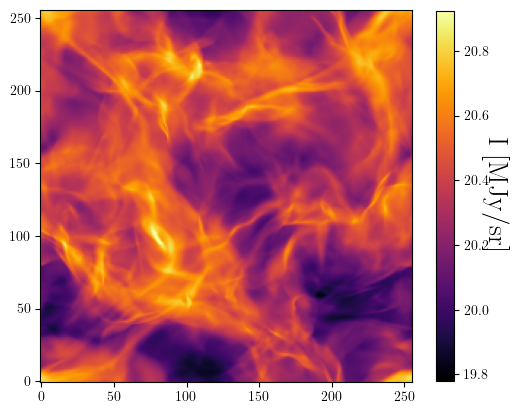

In [4]:
plot(s)

### 2.3. Mock data generation

Now, we will create a noisy mock map and apply the component separation algorithm in order to separate the dust from the noise. \
We begin by choosing the signal-to-noise ratio of the noisy map :

In [5]:
SNR = 2

The noisy map `d` is then defined as $d = s + n$ where `n` is the noise map with $\sigma(s) / \sigma(n)$ = `SNR`.

In [6]:
n = np.random.normal(0,np.std(s)/SNR,size=np.shape(s)).astype(np.float64)
d = s + n

We can plot it :

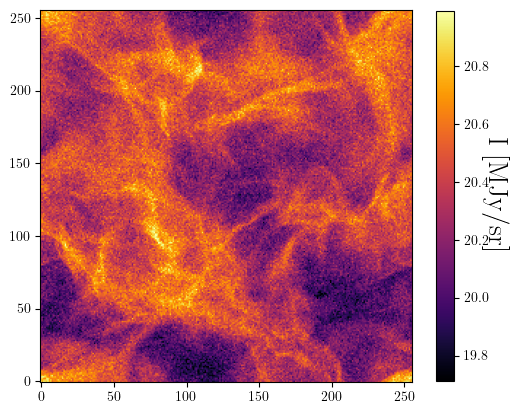

In [7]:
plot(d)

and compare the power spectra of `d`, `s` and `n` :

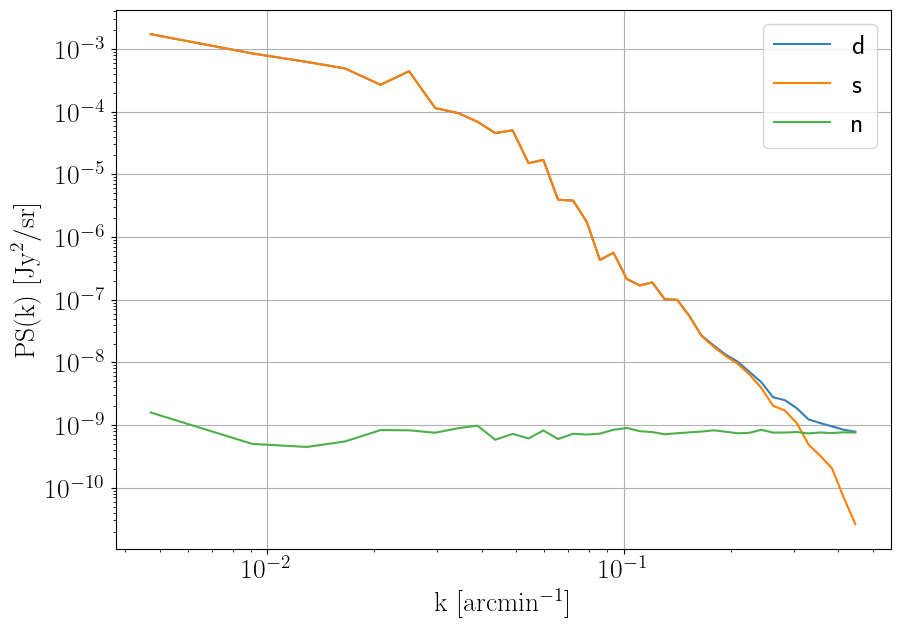

In [8]:
plot_PS(np.array([d,s,n]),labels=['d','s','n'])

We see that `d` has more power at the smallest scales than `s` because of the noise. 

We also generate a set of `Mn` noise realizations that we will need for the component separation.

In [9]:
Mn = 20
noise = np.random.normal(0,np.std(s)/SNR,size=(Mn,np.shape(s)[0],np.shape(s)[0])).astype(np.float64)

We take here only 20 noise realizations for computational reasons.

### 2.4. Parameters setting

This algorithm contains several parameters that we present. \
Some concern the WPH statistics, while others concern the component separation algorithm itself.

#### 2.4.1. WPH statistics parameters

`N` is the size of the map. We work here with square maps. \
`J` is the number of dyadic scales to be taken into account. The largest scale in pixel is $2^{J}$. The default is $\lfloor \log_2 N \rfloor - 2$. \
`L` is the number of orientations in $[0,\pi]$. The default is 4. \
`pbc` stands for "periodic boundary conditions". The default is False but it can be set to True for periodic maps. When pbc = False, the component separation does not take into account the $2^{J-1}$ pixels border of the map. \
`dn` is the number of translations in the computation of the WPH statistics. The translations help to characterize very complex structures as long thin filaments. The default is 5. \
`wph_model` contains the WPH coefficients that will be used. The default is $[S^{11},S^{00},S^{01},C^{phase},C^{01},C^{00},L]$.

In [10]:
N, N = np.shape(s) # map size
J = int(np.log2(N))-2 # number of scales
L = 4 # number of angles
pbc = True # periodic boundary conditions
dn = 5 # number of translations
wph_model = ["S11","S00","S01","Cphase","C01","C00","L"] # list of WPH coefficients

#### 2.4.2 Component separation parameters

`style` defines the formalism used for the loss computation and gradient descent in the algorithm. It can be 'JMD' for Jean-Marc Delouis's formalism or 'BR' for Bruno Régaldo Saint-Blancard's formalism. We use JMD formalism in this tutorial for computational reasons. The user is encouraged to test both styles. \
`method` is the optimizer used in the scipy.optimize.minimize function. The default is L-BFGS-B. \
`n_epoch` is the number of optimization epochs. The default is 5. \
`n_iter` is the number of iteration in each epoch of optimization. The default is 50. \
`device` is the device on which the computation are done. \
`batch_size` is the number of maps in each batch. The default is 5. The value can be increased in order to speed up the algorithm but it requires more memory. 

In [11]:
style = 'JMD'
method = 'L-BFGS-B'
n_epoch = 5
n_iter = 50
device = "cpu"
batch_size = 5

### 2.5. Initialization

#### 2.5.1. Creation of the batches

We group the noise maps in batches in order to speed up the computations of the WPH statistics. 

In [12]:
batch_number = int(Mn/batch_size)
n_batch = create_batch(noise, device, batch_number, batch_size, N)

#### 2.5.2 WPH operator

We can now define the WPH operator that will compute the statistics.

In [13]:
wph_op = pw.WPHOp(N, N, J, L=L, dn=dn, device=device)

#### 2.5.3. Objective function

The objective function is the one which computes the loss function. \
This function takes the flattened running map as an input and returns the loss value and its gradient. 

In [14]:
def objective(x):
    """
    Computes the loss and the corresponding gradient.

    Parameters
    ----------
    x : torch 1D tensor
        Flattened running map.

    Returns
    -------
    float
        Loss value.
    torch 1D tensor
        Gradient of the loss.

    """
    global eval_cnt
    global loss_list
    start_time = time.time()
    u = x.reshape((N, N)) # Reshape x
    u = torch.from_numpy(u).to(device).requires_grad_(True) # Track operations on u
    if style == 'BR':
        L = compute_loss_BR(u, coeffs_target, std, mask, device, Mn, wph_op, noise, pbc) # Compute the loss 'à la Bruno'
    if style == 'JMD':
        L = compute_loss_JMD(u, coeffs_target, std, mask, device, wph_op, pbc) # Compute the loss 'à la Jean-Marc'
    u_grad = u.grad.cpu().numpy().astype(x.dtype) # Compute the gradient
    if eval_cnt % 5 == 0:
        print(f"Evaluation: {eval_cnt}")
        print("L = "+str(round(L.item(),5)))
        print("(computed in "+str(round(time.time() - start_time,3))+"s)")
        print("")
    eval_cnt += 1
    loss_list.append(L.item())
    return L.item(), u_grad.ravel()

### 2.6. Beginning of the optimization

#### 2.6.1. First step

The first step of the algorithm gives an `s_tilde0` map which has the proper power spectrum. The running map is plotted at the end of each epoch.

Starting epoch 1...
Computing loss arguments...
Real mask computed : 100 % of coeffs kept !
Imaginary mask computed : 95 % of coeffs kept !
Loss arguments computed !
Beginning optimization...
Evaluation: 0
L = 81.86854
(computed in 0.155s)

Evaluation: 5
L = 7.93449
(computed in 0.171s)

Evaluation: 10
L = 1.38367
(computed in 0.159s)

Evaluation: 15
L = 0.41795
(computed in 0.218s)

Evaluation: 20
L = 0.24364
(computed in 0.217s)

Evaluation: 25
L = 0.14371
(computed in 0.203s)

Evaluation: 30
L = 0.11153
(computed in 0.214s)

Evaluation: 35
L = 0.09205
(computed in 0.167s)

Evaluation: 40
L = 0.07386
(computed in 0.198s)

Evaluation: 45
L = 0.06591
(computed in 0.205s)

Evaluation: 50
L = 0.05944
(computed in 0.137s)

Epoch 1 done !


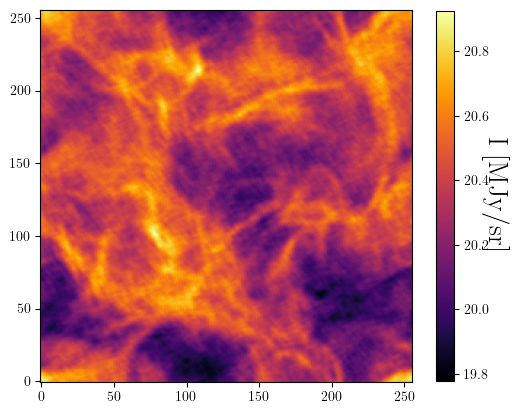

Starting epoch 2...
Computing loss arguments...
Real mask computed : 100 % of coeffs kept !
Imaginary mask computed : 95 % of coeffs kept !
Loss arguments computed !
Beginning optimization...
Evaluation: 55
L = 0.13666
(computed in 0.215s)

Evaluation: 60
L = 0.12137
(computed in 0.233s)

Evaluation: 65
L = 0.10934
(computed in 0.184s)

Evaluation: 70
L = 0.09872
(computed in 0.205s)

Evaluation: 75
L = 0.09198
(computed in 0.203s)

Evaluation: 80
L = 0.08776
(computed in 0.203s)

Evaluation: 85
L = 0.08414
(computed in 0.183s)

Evaluation: 90
L = 0.08124
(computed in 0.181s)

Evaluation: 95
L = 0.07803
(computed in 0.185s)

Evaluation: 100
L = 0.0764
(computed in 0.202s)

Epoch 2 done !


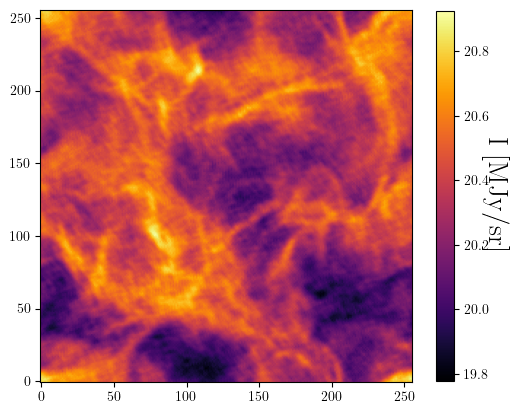

Starting epoch 3...
Computing loss arguments...
Real mask computed : 100 % of coeffs kept !
Imaginary mask computed : 95 % of coeffs kept !
Loss arguments computed !
Beginning optimization...
Evaluation: 105
L = 0.07566
(computed in 0.128s)

Evaluation: 110
L = 0.07498
(computed in 0.135s)

Evaluation: 115
L = 0.07434
(computed in 0.213s)

Evaluation: 120
L = 0.07363
(computed in 0.163s)

Evaluation: 125
L = 0.07292
(computed in 0.192s)

Evaluation: 130
L = 0.07207
(computed in 0.205s)

Evaluation: 135
L = 0.07126
(computed in 0.211s)

Evaluation: 140
L = 0.07073
(computed in 0.185s)

Evaluation: 145
L = 0.07004
(computed in 0.13s)

Evaluation: 150
L = 0.06938
(computed in 0.212s)

Evaluation: 155
L = 0.06869
(computed in 0.193s)

Epoch 3 done !


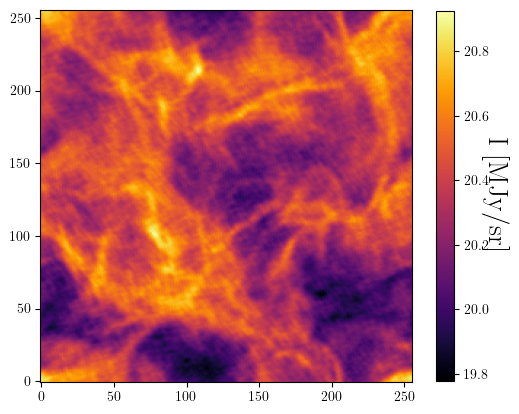

Starting epoch 4...
Computing loss arguments...
Real mask computed : 100 % of coeffs kept !
Imaginary mask computed : 95 % of coeffs kept !
Loss arguments computed !
Beginning optimization...
Evaluation: 160
L = 4.85976
(computed in 0.208s)

Evaluation: 165
L = 0.0685
(computed in 0.187s)

Evaluation: 170
L = 0.06827
(computed in 0.212s)

Evaluation: 175
L = 0.06808
(computed in 0.164s)

Evaluation: 180
L = 0.0679
(computed in 0.246s)

Evaluation: 185
L = 0.06773
(computed in 0.182s)

Evaluation: 190
L = 0.06756
(computed in 0.204s)

Evaluation: 195
L = 0.06736
(computed in 0.204s)

Evaluation: 200
L = 0.06719
(computed in 0.197s)

Evaluation: 205
L = 0.067
(computed in 0.201s)

Evaluation: 210
L = 0.06678
(computed in 0.171s)

Epoch 4 done !


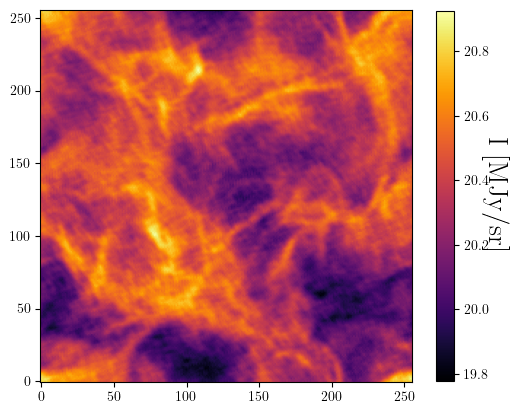

Starting epoch 5...
Computing loss arguments...
Real mask computed : 100 % of coeffs kept !
Imaginary mask computed : 95 % of coeffs kept !
Loss arguments computed !
Beginning optimization...
Evaluation: 215
L = 0.06665
(computed in 0.158s)

Evaluation: 220
L = 0.06656
(computed in 0.193s)

Evaluation: 225
L = 0.06644
(computed in 0.128s)

Evaluation: 230
L = 0.06635
(computed in 0.18s)

Evaluation: 235
L = 0.06625
(computed in 0.194s)

Evaluation: 240
L = 0.06617
(computed in 0.193s)

Evaluation: 245
L = 0.0661
(computed in 0.195s)

Evaluation: 250
L = 0.06602
(computed in 0.208s)

Evaluation: 255
L = 0.06594
(computed in 0.202s)

Evaluation: 260
L = 0.06587
(computed in 0.204s)

Evaluation: 265
L = 0.06581
(computed in 0.179s)

Epoch 5 done !


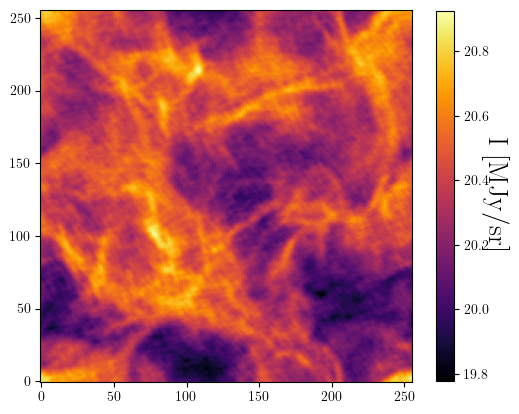

In [15]:
# Initialization of evaluation count.
eval_cnt = 0
# Initialization of the running map s_tilde0.
s_tilde0 = d
# Creation of the loss list.
loss_list = []
# WPH model loading (only the power-spectrum-like coefficients in the first step).
wph_op.load_model(["S11"])
# Loop of the epochs.
for i in range(n_epoch):
    print("Starting epoch "+str(i+1)+"...")
    # Bring s_tilde0 from array to tensor.
    s_tilde0 = torch.from_numpy(s_tilde0).to(device)
    print('Computing loss arguments...')
    # Computation of the noise-induced bias and std on the s_tilde0 map.
    # The bias is only used for style='JMD', but is computed 
    # in both cases (no significant additional calculations).
    bias, std = compute_bias_std(s_tilde0, n_batch, wph_op, pbc, Mn, batch_number, batch_size, device)
    # Computation of the WPH statistics of "d".
    coeffs = wph_op.apply(torch.from_numpy(d).to(device), norm=None, pbc=pbc)
    if style == 'BR':
        # In BR's formalism, the target WPH coefficients are the ones of "d". 
        # They are split into real and imaginary parts.
        coeffs_target = torch.cat((torch.unsqueeze(torch.real(coeffs),dim=0),
                                   torch.unsqueeze(torch.imag(coeffs),dim=0)))
    if style == 'JMD':
        # In JMD's formalism, the target WPH coefficients are computed as 
        # the ones of "d" corrected from the bias estimated before.
        # They are here also split into real and imaginary parts.
        coeffs_target = torch.cat((torch.unsqueeze(torch.real(coeffs)-bias[0],dim=0),
                                   torch.unsqueeze(torch.imag(coeffs)-bias[1],dim=0)))
    # Computation of the mask for the WPH statistics threshold.
    mask = compute_mask(1, s_tilde0, std, wph_op, wph_model, pbc, device)
    print('Loss arguments computed !')
    print('Beginning optimization...')
    # Beginning of the optimization.
    result = opt.minimize(objective, s_tilde0.cpu().ravel(), method=method, jac=True, tol=None,
                          options={"maxiter": n_iter, "gtol": 1e-14, "ftol": 1e-14, "maxcor": 20})
    final_loss, s_tilde0, niter, msg = result['fun'], result['x'], result['nit'], result['message']
    # Reshaping of the running map s_tilde0.
    s_tilde0 = s_tilde0.reshape((N, N)).astype(np.float64)
    print("Epoch "+str(i+1)+" done !")
    # Plot of the running map.
    plot(s_tilde0)

We can plot the loss values: 

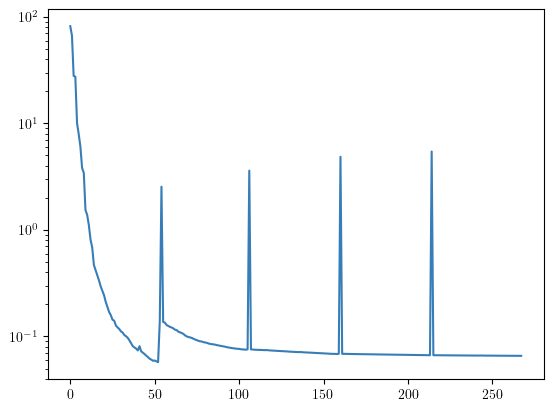

In [16]:
plt.figure()
plt.plot(loss_list)
plt.yscale('log')
plt.show()

We see that the loss decreases well. The peaks correspond to the beginning of each epochs where the standard deviation of the WPH statistics are re-evaluated. The loss normalization changes and then the loss value.

We can also plot the power spectrum of `s_tilde0` and compare it with the ones of `d` and `s` :

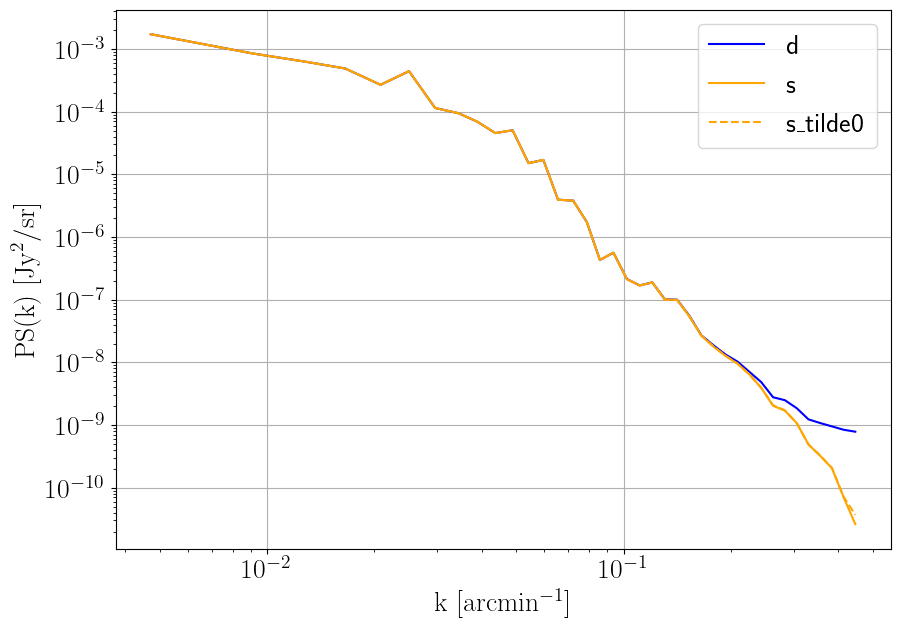

In [17]:
plot_PS(
        np.array([d,s,s_tilde0]),
        labels=['d','s','s_tilde0'],
        colors=['blue','orange','orange'],
        styles=['-','-','--']
        )

As expected, the `s_tilde0` map has the same power spectrum as `s` but when looking at the maps we clearly see that it does not constitute a good statistical model of `s`. This is why we have to do a second step of optimization including all the WPH statistics.

#### 2.6.2. Second step

The second step starts from the results of the first step `s_tilde0`. We run the algorithm a second time but now with all the WPH statistics. 

Starting epoch 1...
Computing loss arguments...
Real mask computed : 100 % of coeffs kept !
Imaginary mask computed : 83 % of coeffs kept !
Loss arguments computed !
Beginning optimization...
Evaluation: 0
L = 2.6845
(computed in 3.09s)

Evaluation: 5
L = 0.35419
(computed in 3.188s)

Evaluation: 10
L = 0.22227
(computed in 3.142s)

Evaluation: 15
L = 0.15517
(computed in 3.178s)

Evaluation: 20
L = 0.12284
(computed in 3.201s)

Evaluation: 25
L = 0.09914
(computed in 3.276s)

Evaluation: 30
L = 0.08774
(computed in 3.291s)

Evaluation: 35
L = 0.07979
(computed in 3.34s)

Evaluation: 40
L = 0.07321
(computed in 3.396s)

Evaluation: 45
L = 0.06802
(computed in 3.313s)

Evaluation: 50
L = 0.06432
(computed in 3.324s)

Epoch 1 done !


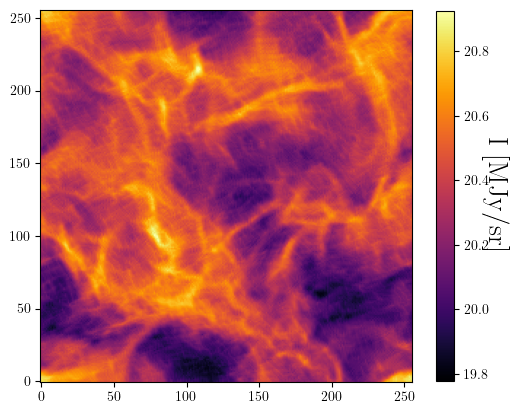

Starting epoch 2...
Computing loss arguments...
Real mask computed : 100 % of coeffs kept !
Imaginary mask computed : 83 % of coeffs kept !
Loss arguments computed !
Beginning optimization...
Evaluation: 55
L = 2.74861
(computed in 3.376s)

Evaluation: 60
L = 0.1699
(computed in 3.563s)

Evaluation: 65
L = 0.13535
(computed in 3.364s)

Evaluation: 70
L = 0.12295
(computed in 3.464s)

Evaluation: 75
L = 0.11555
(computed in 3.403s)

Evaluation: 80
L = 0.11109
(computed in 3.395s)

Evaluation: 85
L = 0.10728
(computed in 2.878s)

Evaluation: 90
L = 0.10436
(computed in 2.736s)

Evaluation: 95
L = 0.10093
(computed in 2.759s)

Evaluation: 100
L = 0.09883
(computed in 2.768s)

Evaluation: 105
L = 0.09713
(computed in 2.901s)

Epoch 2 done !


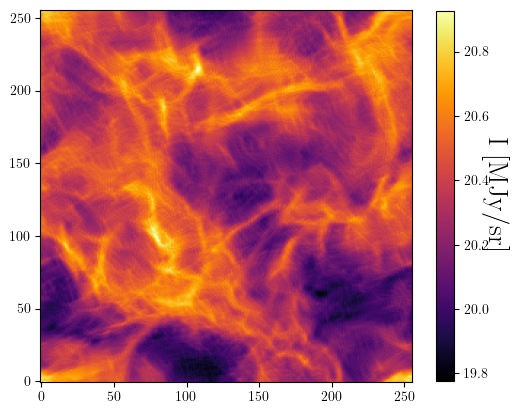

Starting epoch 3...
Computing loss arguments...
Real mask computed : 100 % of coeffs kept !
Imaginary mask computed : 83 % of coeffs kept !
Loss arguments computed !
Beginning optimization...
Evaluation: 110
L = 0.19165
(computed in 3.065s)

Evaluation: 115
L = 0.14462
(computed in 2.979s)

Evaluation: 120
L = 0.1365
(computed in 3.041s)

Evaluation: 125
L = 0.13347
(computed in 3.04s)

Evaluation: 130
L = 0.13147
(computed in 2.874s)

Evaluation: 135
L = 0.12919
(computed in 2.951s)

Evaluation: 140
L = 0.12692
(computed in 2.928s)

Evaluation: 145
L = 0.12469
(computed in 3.128s)

Evaluation: 150
L = 0.12342
(computed in 3.073s)

Evaluation: 155
L = 0.12196
(computed in 3.058s)

Epoch 3 done !


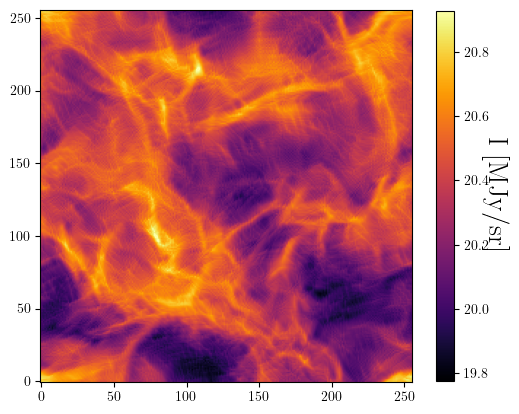

Starting epoch 4...
Computing loss arguments...
Real mask computed : 100 % of coeffs kept !
Imaginary mask computed : 83 % of coeffs kept !
Loss arguments computed !
Beginning optimization...
Evaluation: 160
L = 0.21326
(computed in 3.081s)

Evaluation: 165
L = 0.15166
(computed in 2.971s)

Evaluation: 170
L = 0.14355
(computed in 2.858s)

Evaluation: 175
L = 0.14054
(computed in 2.862s)

Evaluation: 180
L = 0.13937
(computed in 2.858s)

Evaluation: 185
L = 0.13832
(computed in 3.185s)

Evaluation: 190
L = 0.13735
(computed in 3.052s)

Evaluation: 195
L = 0.13726
(computed in 3.071s)

Evaluation: 200
L = 0.13517
(computed in 3.126s)

Evaluation: 205
L = 0.13464
(computed in 3.063s)

Evaluation: 210
L = 0.13318
(computed in 3.122s)

Epoch 4 done !


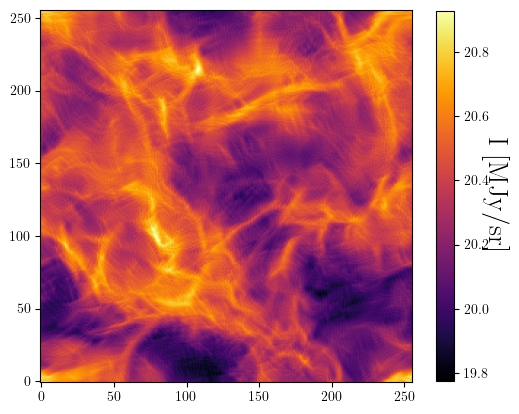

Starting epoch 5...
Computing loss arguments...
Real mask computed : 100 % of coeffs kept !
Imaginary mask computed : 83 % of coeffs kept !
Loss arguments computed !
Beginning optimization...
Evaluation: 215
L = 2.11642
(computed in 2.944s)

Evaluation: 220
L = 0.14558
(computed in 2.827s)

Evaluation: 225
L = 0.14284
(computed in 3.082s)

Evaluation: 230
L = 0.14123
(computed in 3.062s)

Evaluation: 235
L = 0.14043
(computed in 3.058s)

Evaluation: 240
L = 0.1398
(computed in 3.095s)

Evaluation: 245
L = 0.13934
(computed in 3.081s)

Evaluation: 250
L = 0.13841
(computed in 3.008s)

Evaluation: 255
L = 0.13762
(computed in 3.109s)

Evaluation: 260
L = 0.13693
(computed in 3.076s)

Evaluation: 265
L = 0.13608
(computed in 2.806s)

Epoch 5 done !


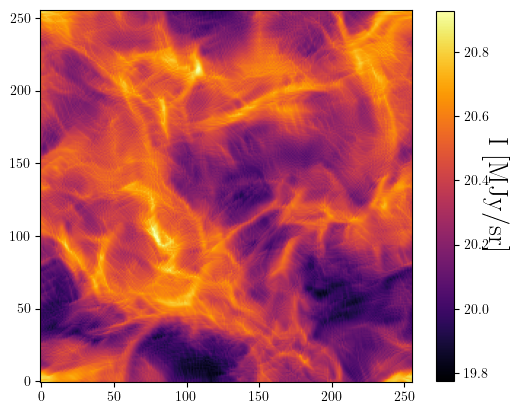

In [20]:
# Initialization of evaluation count.
eval_cnt = 0
# Initialization of the running map s_tilde.
s_tilde = s_tilde0
# Creation of the loss list.
loss_list = []
# WPH model loading (all the WPH coefficients in the second step).
wph_op.load_model(wph_model)
# Loop of the epochs.
for i in range(n_epoch):
    print("Starting epoch "+str(i+1)+"...")
    # Bring s_tilde from array to tensor.
    s_tilde = torch.from_numpy(s_tilde).to(device)
    print('Computing loss arguments...')
    # Computation of the noise-induced bias and std on the s_tilde map.
    # The bias is only used for style='JMD', but is computed
    # in both cases (no significant additional calculations).
    bias, std = compute_bias_std(s_tilde, n_batch, wph_op, pbc, Mn, batch_number, batch_size, device)
    # Computation of the WPH statistics of "d".
    coeffs = wph_op.apply(torch.from_numpy(d).to(device), norm=None, pbc=pbc)
    if style == 'BR':
        # In BR's formalism, the target WPH coefficients are the ones of "d". 
        # They are split into real and imaginary parts.
        coeffs_target = torch.cat((torch.unsqueeze(torch.real(coeffs),dim=0),
                                   torch.unsqueeze(torch.imag(coeffs),dim=0)))
    if style == 'JMD':
        # In JMD's formalism, the target WPH coefficients are computed as 
        # the ones of "d" corrected from the bias estimated before.
        # They are here also split into real and imaginary parts.
        coeffs_target = torch.cat((torch.unsqueeze(torch.real(coeffs)-bias[0],dim=0),
                                   torch.unsqueeze(torch.imag(coeffs)-bias[1],dim=0)))
    # Computation of the mask for the WPH statistics threshold.
    mask = compute_mask(2, s_tilde, std, wph_op, wph_model, pbc, device)
    print('Loss arguments computed !')
    print('Beginning optimization...')
    # Beginning of the optimization.
    result = opt.minimize(objective, s_tilde.cpu().ravel(), method=method, jac=True, tol=None, 
                          options={"maxiter": n_iter, "gtol": 1e-14, "ftol": 1e-14, "maxcor": 20})
    final_loss, s_tilde, niter, msg = result['fun'], result['x'], result['nit'], result['message']
    # Reshaping of the running map s_tilde.
    s_tilde = s_tilde.reshape((N, N)).astype(np.float64)
    print("Epoch "+str(i+1)+" done !")
    # Plot of the running map.
    plot(s_tilde)

We can plot the loss values:

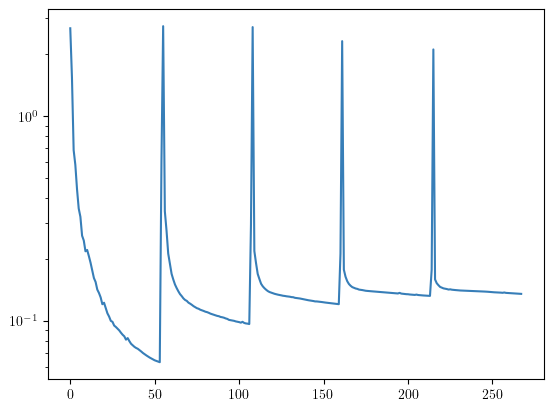

In [21]:
plt.figure()
plt.plot(loss_list)
plt.yscale('log')
plt.show()

Here also, the peaks correspond to the beginning of each epoch. The loss seems to have reached a plateau.

### 2.7. End

We can now plot the output dust map `s_tilde`. As the edges have not been processed by the separation, only the central part is displayed.

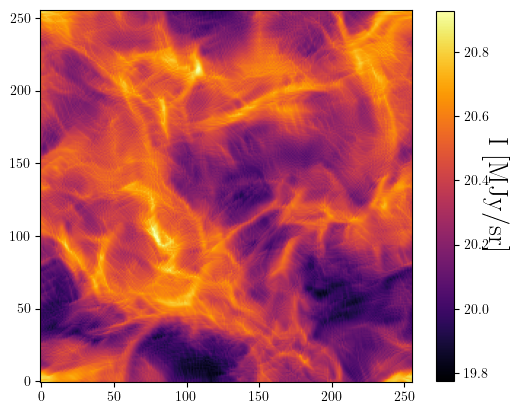

In [22]:
plot(s_tilde)

This maps seems to be noise-free. It however presents some artifacts that are due to the small size of the map and to the JMD formalism. \
A run with a larger map on a GPU and/or in the BR formalism would give less artifacts. 